# Modeling the Affinity of Customers

## Import libraries

In [368]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Encoders
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder

# Scalers
from sklearn.preprocessing import MinMaxScaler

# Models
from sklearn.linear_model import LogisticRegression

# Cross validation
from sklearn.model_selection import cross_val_score

# Train/test split
from sklearn.model_selection import train_test_split

# Pipeline
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline

# ColumnTransformer
from sklearn.compose import ColumnTransformer

# Oversampling SMOTE
from imblearn.over_sampling import SMOTE

## Exploratory Data Analysis

In [261]:
# Import csv files as pandas dataframe
customer = pd.read_csv("data/rest.csv", sep = ";")
age_and_sex = pd.read_csv("data/alter_geschlecht.csv")
interest = pd.read_csv("data/interesse.csv")

In [262]:
customer.head()

,Fahrerlaubnis,Regional_Code,Vorversicherung,Alter_Fzg,Vorschaden,Jahresbeitrag,Vertriebskanal,Kundentreue,id
0,1,15.0,1,1-2 Year,No,2630.0,124.0,74,317635
1,1,28.0,0,1-2 Year,Yes,2630.0,125.0,213,337993
2,1,33.0,0,1-2 Year,Yes,27204.0,124.0,114,160325
3,1,46.0,1,< 1 Year,No,31999.0,152.0,251,141620
4,1,49.0,0,1-2 Year,Yes,28262.0,26.0,60,75060


In [263]:
age_and_sex.head()

,id,Geschlecht,Alter
0,170727,Male,42
1,41795,Male,24
2,369321,Female,30
3,500463,Female,32
4,327695,Male,34


In [264]:
interest.head()

,id,Interesse
0,1,1.0
1,2,0.0
2,3,1.0
3,4,0.0
4,5,0.0


In [265]:
# Exploring lenght of the tables
print(len(customer))
print(len(age_and_sex))
print(len(interest))

508146
508146
381109


Interest table contains fewer rows than two other tables => In this scenario, we should only keep the rows in the "customer" and "age_and_sex" dataframes that match the IDs in the "interest" dataframe since the "interest" dataframe contains the target variable we want to predict. The rest we can keep for predicting after training the model

In [320]:
# Merge dataframes -> use left join for interest table
data = interest.merge(age_and_sex, on='id', how='left')
data = data.merge(customer, on='id', how='left')
data.head()

,id,Interesse,Geschlecht,Alter,Fahrerlaubnis,Regional_Code,Vorversicherung,Alter_Fzg,Vorschaden,Jahresbeitrag,Vertriebskanal,Kundentreue
0,1,1.0,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217
1,2,0.0,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183
2,3,1.0,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27
3,4,0.0,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203
4,5,0.0,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39


In [291]:
# Examine the structure of the table
print(data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 381109 entries, 0 to 381108
Data columns (total 12 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   id               381109 non-null  int64  
 1   Interesse        381109 non-null  float64
 2   Geschlecht       381109 non-null  object 
 3   Alter            381109 non-null  int64  
 4   Fahrerlaubnis    381109 non-null  int64  
 5   Regional_Code    381109 non-null  float64
 6   Vorversicherung  381109 non-null  int64  
 7   Alter_Fzg        381109 non-null  object 
 8   Vorschaden       381109 non-null  object 
 9   Jahresbeitrag    381109 non-null  float64
 10  Vertriebskanal   381109 non-null  float64
 11  Kundentreue      381109 non-null  int64  
dtypes: float64(4), int64(5), object(3)
memory usage: 37.8+ MB
None


In [292]:
# Explore missing values
print(data.isna().sum()) # -> no missing values

id                 0
Interesse          0
Geschlecht         0
Alter              0
Fahrerlaubnis      0
Regional_Code      0
Vorversicherung    0
Alter_Fzg          0
Vorschaden         0
Jahresbeitrag      0
Vertriebskanal     0
Kundentreue        0
dtype: int64


In [293]:
# Explore duplicated rows
print(data.duplicated().sum()) # -> no duplicates

0


In [294]:
# Detecting outliers

# Check categorical features on unexpected values
print(data["Interesse"].unique())
print(data["Geschlecht"].unique())
print(data["Fahrerlaubnis"].unique())
print(data["Vorversicherung"].unique())
print(data["Alter_Fzg"].unique())
print(data["Vorschaden"].unique())

[1. 0.]
['Male' 'Female']
[1 0]
[0 1]
['> 2 Years' '1-2 Year' '< 1 Year']
['Yes' 'No']


In [295]:
# Check values in Regional_Code
np.sort(data['Regional_Code'].unique()) # -> 53 regions

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
       26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38.,
       39., 40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50., 51.,
       52.])

In [296]:
# Check values in Vertriebskanal
np.sort(data['Vertriebskanal'].unique()) # -> 163 channels

array([  1.,   2.,   3.,   4.,   6.,   7.,   8.,   9.,  10.,  11.,  12.,
        13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,  22.,  23.,
        24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,  33.,  34.,
        35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,  44.,  45.,
        46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,  55.,  56.,
        57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,  66.,  67.,
        68.,  69.,  70.,  71.,  73.,  74.,  75.,  76.,  78.,  79.,  80.,
        81.,  82.,  83.,  84.,  86.,  87.,  88.,  89.,  90.,  91.,  92.,
        93.,  94.,  95.,  96.,  97.,  98.,  99., 100., 101., 102., 103.,
       104., 105., 106., 107., 108., 109., 110., 111., 112., 113., 114.,
       115., 116., 117., 118., 119., 120., 121., 122., 123., 124., 125.,
       126., 127., 128., 129., 130., 131., 132., 133., 134., 135., 136.,
       137., 138., 139., 140., 143., 144., 145., 146., 147., 148., 149.,
       150., 151., 152., 153., 154., 155., 156., 15

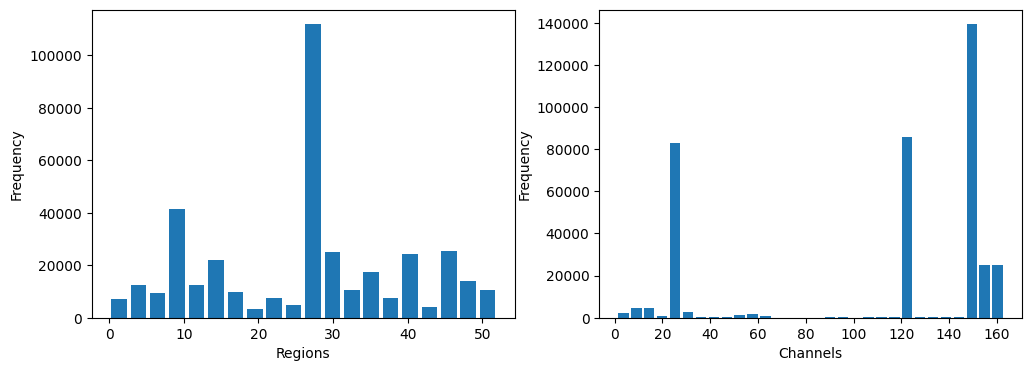

In [297]:
# Check Regional_Code and Vertriebskanal distribution
fig = plt.figure(figsize=(12,4))

plt.subplot(1, 2, 1)
plt.hist(data['Regional_Code'], bins=20, rwidth=0.8)
plt.xlabel('Regions')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(data['Vertriebskanal'], bins=30, rwidth=0.8)
plt.xlabel('Channels')
plt.ylabel('Frequency')

plt.show()

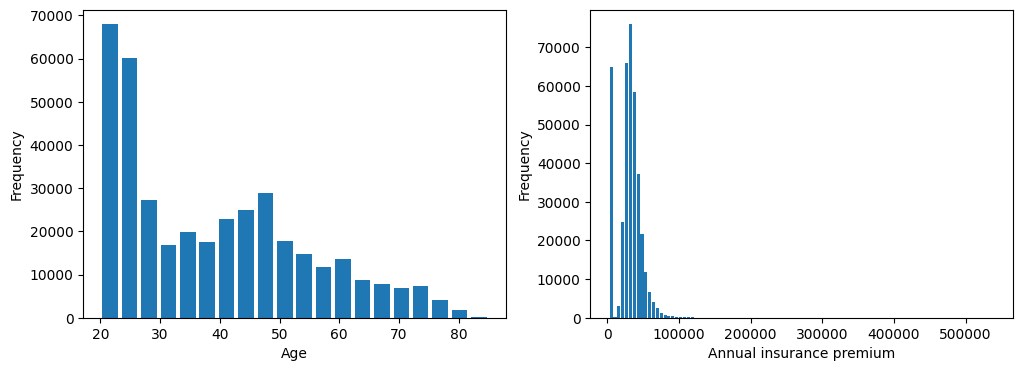

In [232]:
# Check numerical features

# Check age and annual premium
fig = plt.figure(figsize=(12,4))

plt.subplot(1, 2, 1)
plt.hist(data['Alter'], bins=20, rwidth=0.8)
plt.xlabel('Age')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(data['Jahresbeitrag'], bins=100, rwidth=0.8)
plt.xlabel('Annual insurance premium')
plt.ylabel('Frequency')

plt.show()

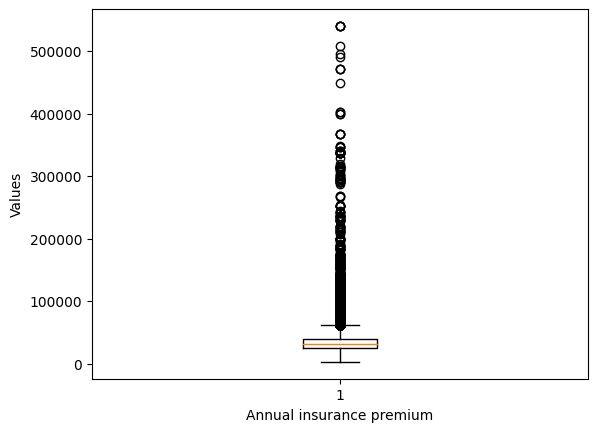

In [233]:
# Plot boxplot of Jahresbeitrag column
plt.boxplot(data['Jahresbeitrag'])
plt.xlabel('Annual insurance premium')
plt.ylabel('Values')
plt.show()

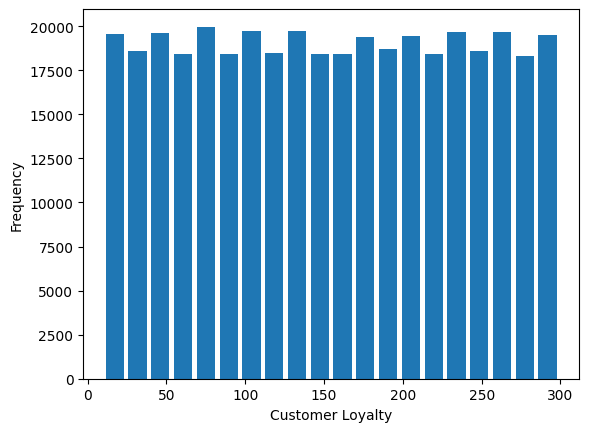

In [234]:
# Check values in Kundentreue
plt.hist(data['Kundentreue'], bins=20, rwidth=0.8)
plt.xlabel('Customer Loyalty')
plt.ylabel('Frequency')
plt.show()

Conclusions:
We have 7 categoracal variables: Geschlecht, Fahrerlaubnis, Regional_Code, Vorversicherung, Alter_Fzg, Vorschaden and Vertriebskanal. Some of them need to be encoded:
* Geschlecht -> one-hot-encoding since they don't have ordinal structure
* Alter_Fzg -> ordinal encoder since they have hierarchy
* Vorschaden -> label encoder that put 1 if there are previous damages and 0 if not
* Regional_Code and Vertriebskanal -> it is necessary to encode them using different strategy since some algorithms are sensitive to the ordering of the categories and may assign a higher weight to categories with larger numerical values -> use target encoding

Our numerical values are: Alter, Jahresbeitrag and Kundentreue.

* Jahresbeitrag -> has a lot of extreme values but I think that they are full part of the dataset and shouldn't be removed -> MinMax Scaling
* Alter -> MinMax Scaling as for Jahresbeitrag. Also, it may make sense to discretize Alter column into groups according to car accident statistics (https://www.gdv.de/gdv/themen/mobilitaet/so-wirkt-sich-das-alter-auf-den-kfz-versicherungsbeitrag-aus-12464)
* Kundentreue -> MinMax Scaling as for Jahresbeitrag

Note: I will first proceed with logistic regression, such algorithms assume that the input variables are on the same scale and that the scale of the coefficients is meaningful. That is why I need to scale my variables. I will also later try other algorithms such as random forest. Such algorithms are not sensitive to the scale of the features, so normalization or scaling is not necessary. But still scaling doesn't hurt.

## Feature Engineering and Encoding

In [321]:
# Discretize Alter column
bins = [0, 30, 50, 65, 75, 100]
bin_labels = ['<30', '30-50', '50-65', '65-75', '>75']
data['Alter_binned'] = pd.cut(data['Alter'], bins=bins, labels=bin_labels, right=False)

In [322]:
# one-hot encode the Alter_binned column
data = pd.get_dummies(data, columns=['Alter_binned'])

In [323]:
# Drop the column "id" since we don't need it anymore
data.drop(columns = ["id"], inplace = True)

In [324]:
# Encoding Regional_Code and Vertriebskanal 

# Import function from utils
from utils.functions import calc_target_encoding

# Apply function to Regional_Code and Vertriebskanal columns
target_mean_regional = calc_target_encoding(data, 'Regional_Code', 'Interesse')
target_mean_channel = calc_target_encoding(data, 'Vertriebskanal', 'Interesse')

# Apply target encoding to the original data
data['Regional_Code_enc'] = data['Regional_Code'].map(target_mean_regional)
data['Vertriebskanal_enc'] = data['Vertriebskanal'].map(target_mean_channel)

# Drop columns which have been encoded
data.drop(columns = ["Regional_Code"], inplace = True)
data.drop(columns = ["Vertriebskanal"], inplace = True)

In [325]:
# Alter_Fzg

# Instantiate the OrdinalEncoder
ordinal_encoder = OrdinalEncoder()

# Define the mapping for each category in the "Alter_Fzg" column
ordinal_mapping = {"< 1 Year": 0, "1-2 Year": 1, "> 2 Years": 2}

# Creating an array that contains the categories of the "Alter_Fzg" column
Alter_Fzg_array = data['Alter_Fzg'].map(lambda x: ordinal_mapping[x]).values.reshape(-1, 1)

# Fit and transform the Alter_Fzg_array to a numerical representation
Alter_Fzg_encoded = ordinal_encoder.fit_transform(Alter_Fzg_array)

# Adding the encoded "Alter_Fzg" column to the original dataframe
data['Alter_Fzg_enc'] = Alter_Fzg_encoded

# Drop the column "Alter_Fzg" which has been encoded
data.drop(columns = ["Alter_Fzg"], inplace = True)

In [326]:
# Geschlecht

# Instantiate the OneHotEncoder
ohe_binary = OneHotEncoder(sparse = False, drop="if_binary") 

# Fit encoder
ohe_binary.fit(data[['Geschlecht']]) 

# Transform the current "Geschlecht" column
data[ohe_binary.get_feature_names_out()] = ohe_binary.transform(data[['Geschlecht']])

# Drop the column "Geschlecht" which has been encoded
data.drop(columns = ["Geschlecht"], inplace = True)

In [327]:
# Vorschaden

# Initialize the LabelEncoder
le = LabelEncoder()

# Fit and transform the Vorschaden column
data['Vorschaden'] = le.fit_transform(data['Vorschaden'].values)

In [328]:
data.head()

,Interesse,Alter,Fahrerlaubnis,Vorversicherung,Vorschaden,Jahresbeitrag,Kundentreue,Alter_binned_<30,Alter_binned_30-50,Alter_binned_50-65,Alter_binned_65-75,Alter_binned_>75,Regional_Code_enc,Vertriebskanal_enc,Alter_Fzg_enc,Geschlecht_Male
0,1.0,44,1,0,1,40454.0,217,0,1,0,0,0,0.187163,0.199385,2.0,1.0
1,0.0,76,1,0,0,33536.0,183,0,0,0,0,1,0.127662,0.199385,1.0,1.0
2,1.0,47,1,0,1,38294.0,27,0,1,0,0,0,0.187163,0.199385,2.0,1.0
3,0.0,21,1,1,0,28619.0,203,1,0,0,0,0,0.112760,0.028624,0.0,1.0
4,0.0,29,1,1,0,27496.0,39,1,0,0,0,0,0.121776,0.028624,0.0,0.0


## Preprocessing Pipeline

In [329]:
# Defining the features and the target
X = data.drop(columns='Interesse')
y = data['Interesse']

# Train-Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((266776, 15), (114333, 15), (266776,), (114333,))

In [332]:
# Scale numerical values: 
num_transformer = Pipeline([('minmax_scaler', MinMaxScaler())])

# Parallelize transformers
preprocessor = ColumnTransformer([
    ('num_transformer', num_transformer, ['Jahresbeitrag', 'Alter', 'Kundentreue'])],
    remainder='passthrough'
)

preprocessor

ColumnTransformer(remainder='passthrough',
                  transformers=[('num_transformer',
                                 Pipeline(steps=[('minmax_scaler',
                                                  MinMaxScaler())]),
                                 ['Jahresbeitrag', 'Alter', 'Kundentreue'])])

In [339]:
X_train_transformed = preprocessor.fit_transform(X_train)

In [340]:
norm_data = pd.DataFrame(
    X_train_transformed, 
    columns=preprocessor.get_feature_names_out())

In [341]:
norm_data.head()

,num_transformer__Jahresbeitrag,num_transformer__Alter,num_transformer__Kundentreue,remainder__Fahrerlaubnis,remainder__Vorversicherung,remainder__Vorschaden,remainder__Alter_binned_<30,remainder__Alter_binned_30-50,remainder__Alter_binned_50-65,remainder__Alter_binned_65-75,remainder__Alter_binned_>75,remainder__Regional_Code_enc,remainder__Vertriebskanal_enc,remainder__Alter_Fzg_enc,remainder__Geschlecht_Male
0,0.043662,0.046154,0.262976,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.073825,0.028624,0.0,1.0
1,0.000000,0.323077,1.000000,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.070310,0.199385,1.0,0.0
2,0.032493,0.369231,0.342561,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.127662,0.199385,1.0,1.0
3,0.053544,0.046154,0.903114,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.121776,0.028624,0.0,1.0
4,0.049913,0.492308,0.093426,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.187163,0.189148,1.0,0.0


## Preliminary Statistical Analysis

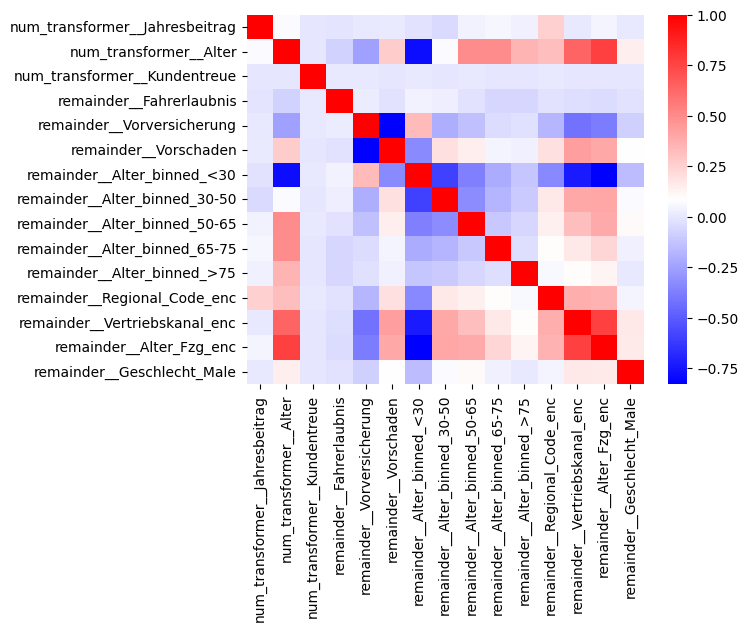

In [342]:
# Heatmap of pairwise correlations
correlation_matrix = norm_data.corr()
column_names = correlation_matrix.columns
sns.heatmap(correlation_matrix, xticklabels=column_names, yticklabels=column_names,cmap= "bwr");

In [343]:
# Converting the correlation matrix into a DataFrame
corr_df = correlation_matrix.stack().reset_index()

# Renaming the columns
corr_df.columns = ['feature_1','feature_2', 'correlation']

# Remove "self correlations"
no_self_correlation = (corr_df['feature_1'] != corr_df['feature_2'])
corr_df = corr_df[no_self_correlation]

In [344]:
# Computing the absolute correlation
corr_df['absolute_correlation'] = np.abs(corr_df['correlation'])

# Showing the top 5 most correlated pairs of feature
corr_df.sort_values(by="absolute_correlation", ascending=False).head(5*2)

,feature_1,feature_2,correlation,absolute_correlation
103,remainder__Alter_binned_<30,remainder__Alter_Fzg_enc,-0.830399,0.830399
201,remainder__Alter_Fzg_enc,remainder__Alter_binned_<30,-0.830399,0.830399
65,remainder__Vorversicherung,remainder__Vorschaden,-0.823262,0.823262
79,remainder__Vorschaden,remainder__Vorversicherung,-0.823262,0.823262
91,remainder__Alter_binned_<30,num_transformer__Alter,-0.787407,0.787407
21,num_transformer__Alter,remainder__Alter_binned_<30,-0.787407,0.787407
207,remainder__Alter_Fzg_enc,remainder__Vertriebskanal_enc,0.768649,0.768649
193,remainder__Vertriebskanal_enc,remainder__Alter_Fzg_enc,0.768649,0.768649
196,remainder__Alter_Fzg_enc,num_transformer__Alter,0.765724,0.765724
28,num_transformer__Alter,remainder__Alter_Fzg_enc,0.765724,0.765724


## Modelling

### Choosing the right metrics

In [350]:
target_count = data['Interesse'].value_counts()
print("Class distribution:")
print(target_count)

Class distribution:
0.0    334399
1.0     46710
Name: Interesse, dtype: int64


In [357]:
# Calculate the ratio of each class
class_ratio = target_count[1] / target_count[0]
print("Ratio of classes:", class_ratio)

Ratio of classes: 0.13968343206767964


Target classes are not balanced -> accuracy isn't an option. Recall is a better choice since we don't want to miss any positive classes (customers that have interest in offer). We want to reduce false negatives (customers who are interested in offer but were recognized as not-interested). 

We can also use F1 score as a combination of precision and recall

### Pipeline

In [353]:
# Instantiate model
log_reg = LogisticRegression(max_iter=1000) 

# Add estimator
pipeline = make_pipeline(preprocessor, log_reg)
pipeline

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num_transformer',
                                                  Pipeline(steps=[('minmax_scaler',
                                                                   MinMaxScaler())]),
                                                  ['Jahresbeitrag', 'Alter',
                                                   'Kundentreue'])])),
                ('logisticregression', LogisticRegression(max_iter=1000))])

In [358]:
# Use recall as the scoring metric
recall_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='recall')
mean_recall = recall_scores.mean()
print("Mean recall score:", mean_recall)

Mean recall score: 0.0038387511933586833


We have an imbalanced dataset and the mean recall score is extremely low, it's likely that the model is biased towards the majority class and is not detecting the minority class well. We can try to oversample minority class.

In [366]:
# Create an instance of the SMOTE class
smote = SMOTE(sampling_strategy='minority', random_state=42)

# Fit the SMOTE model to the training data
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [369]:
# Cross-validate the model again
recall_scores = cross_val_score(pipeline, X_train_resampled, y_train_resampled, cv=5, scoring='recall')
mean_recall = recall_scores.mean()
print("Mean recall score:", mean_recall)

Mean recall score: 0.8932950944195153


It is now far better. We can also try to find good precision-recall tradeoff and optimize threshold for desicion